### Import packages

In [30]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyproj
import pandas as pd
import pygmt
from sklearn.metrics import mean_squared_error
import time

import pooch
import harmonica as hm
import boule as bl
import verde as vd
import ensaio
%load_ext line_profiler



The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [31]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 130

### 1º Teste Harmonica - Função Fit EquivalentSourcesGB

In [32]:
path_to_data = ensaio.fetch_southern_africa_gravity(version=1)
data = pd.read_csv(path_to_data)

In [33]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_sea_level_m)

In [34]:
ellipsoid = bl.WGS84

normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height_sea_level_m)

gravity_disturbance = data.gravity_mgal - normal_gravity

In [35]:
# Profile com 64 bits
# Utilizar a classe Spline para interpolar os dados do GPS com 64 bits

# Cria-se uma instância de Eqs
eqs_64 = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=2e3, window_size=100e3, random_state=42
)
# Realiza-se a interpolação com os dados passados 
%lprun -f hm.EquivalentSourcesGB.fit eqs_64.fit(coordinates, gravity_disturbance)

/mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/gradient_boosted.py:231: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reducti

Timer unit: 1e-09 s

Total time: 10.7219 s
File: /mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/gradient_boosted.py
Function: EquivalentSourcesGB.fit at line 188

Line #      Hits         Time  Per Hit   % Time  Line Contents
   188                                               def fit(self, coordinates, data, weights=None, dtype=None):
   189                                                   """
   190                                                   Fit the coefficients of the equivalent sources.
   191                                           
   192                                                   The fitting process is carried out through the gradient-boosting
   193                                                   algorithm.
   194                                                   The data region is captured and used as default for the
   195                                                   :meth:`~harmonica.EquivalentSourcesGB.grid` method.
   196                 

In [36]:
# Profile com 64 bits
# Utilizar a classe Spline para interpolar os dados do GPS com 64 bits

# Cria-se uma instância de Eqs
eqs_32 = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=2e3, window_size=100e3, random_state=42
)
# Realiza-se a interpolação com os dados passados 
%lprun -f hm.EquivalentSourcesGB.fit eqs_32.fit(coordinates, gravity_disturbance, dtype="float32")

/mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/gradient_boosted.py:231: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reducti

Timer unit: 1e-09 s

Total time: 8.9163 s
File: /mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/gradient_boosted.py
Function: EquivalentSourcesGB.fit at line 188

Line #      Hits         Time  Per Hit   % Time  Line Contents
   188                                               def fit(self, coordinates, data, weights=None, dtype=None):
   189                                                   """
   190                                                   Fit the coefficients of the equivalent sources.
   191                                           
   192                                                   The fitting process is carried out through the gradient-boosting
   193                                                   algorithm.
   194                                                   The data region is captured and used as default for the
   195                                                   :meth:`~harmonica.EquivalentSourcesGB.grid` method.
   196                  

In [37]:
## Código com benchmarking ## 
resultados_benchmark_spline = []
n_repeticoes = 21



for i in range(n_repeticoes):

    seed_atual = 42 + i
    
    start_time = time.perf_counter()


    eqs_64 = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=2e3, window_size=100e3, random_state=seed_atual)
    # Realiza-se a interpolação com os dados passados
    eqs_64.fit(coordinates, gravity_disturbance)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_spline.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=2e3, window_size=100e3, random_state=seed_atual)
    # Realiza-se a interpolação com os dados passados 
    eqs_32.fit(coordinates, gravity_disturbance, dtype="float32")
    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_spline.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_spline.pop(0)
resultados_benchmark_spline.pop(n_repeticoes)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_spline)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados

/mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/gradient_boosted.py:231: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reducti


--- Estatísticas Descritivas por Versão ---
         count      mean       std       min       25%        50%        75%  \
Versão                                                                         
32 bits   20.0  8.791724  1.149025  6.417564  8.479931   9.495956   9.579573   
64 bits   20.0  9.965469  1.301812  7.595299  9.203526  10.086838  10.982616   

               max  
Versão              
32 bits   9.683931  
64 bits  11.950261  


,Versão,Rodada,Duração
0,64 bits,2,11.486816
1,64 bits,3,10.860254
2,64 bits,4,7.665983
3,64 bits,5,11.510544
4,64 bits,6,10.156122
5,64 bits,7,9.861489
6,64 bits,8,10.017554
7,64 bits,9,11.950261
8,64 bits,10,10.230463
9,64 bits,11,9.411426


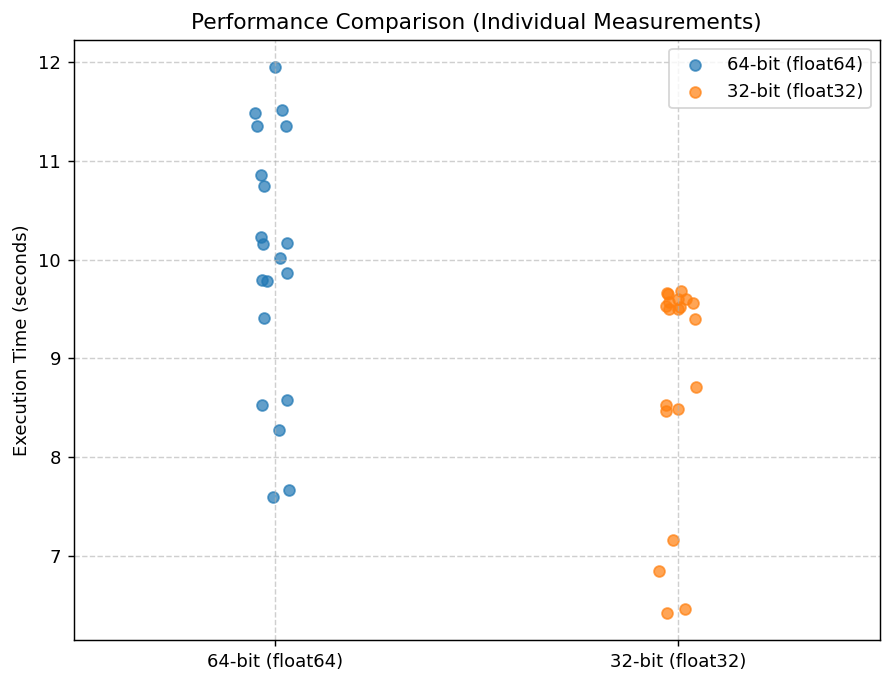

/tmp/ipykernel_21398/981250294.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


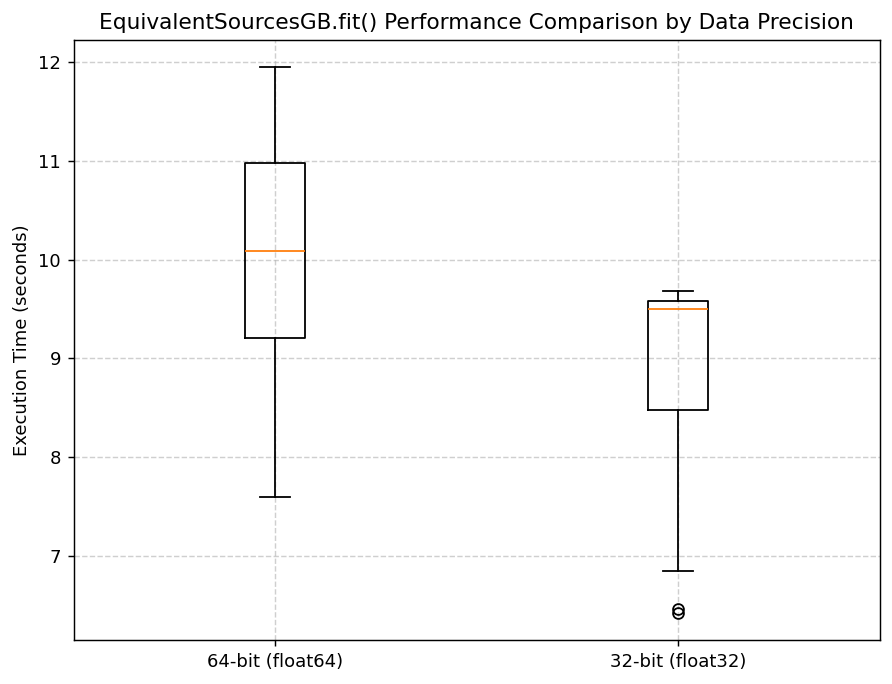

In [38]:
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Performance Comparison (Individual Measurements)')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_caribe.png")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('EquivalentSourcesGB.fit() Performance Comparison by Data Precision')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_caribe.png")
plt.show()

In [39]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=2.5e3,
)
grid_64 = eqs_64.grid(grid_coords, data_names=["gravity_disturbance"])
grid_64


<xarray.Dataset> Size: 3MB
Dimensions:              (northing: 389, easting: 412)
Coordinates:
  * easting              (easting) float64 3kB 1.174e+06 1.179e+06 ... 3.228e+06
  * northing             (northing) float64 3kB -3.665e+06 ... -1.724e+06
    upward               (northing, easting) float64 1MB 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 1MB 5.838 5.852 ... 4.12
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=2000.0, damping=10...

In [40]:
grid_32 = eqs_32.grid(grid_coords, data_names=["gravity_disturbance"])
grid_32

<xarray.Dataset> Size: 3MB
Dimensions:              (northing: 389, easting: 412)
Coordinates:
  * easting              (easting) float64 3kB 1.174e+06 1.179e+06 ... 3.228e+06
  * northing             (northing) float64 3kB -3.665e+06 ... -1.724e+06
    upward               (northing, easting) float64 1MB 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 1MB 5.838 5.852 ... 4.12
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=2000.0, damping=10...

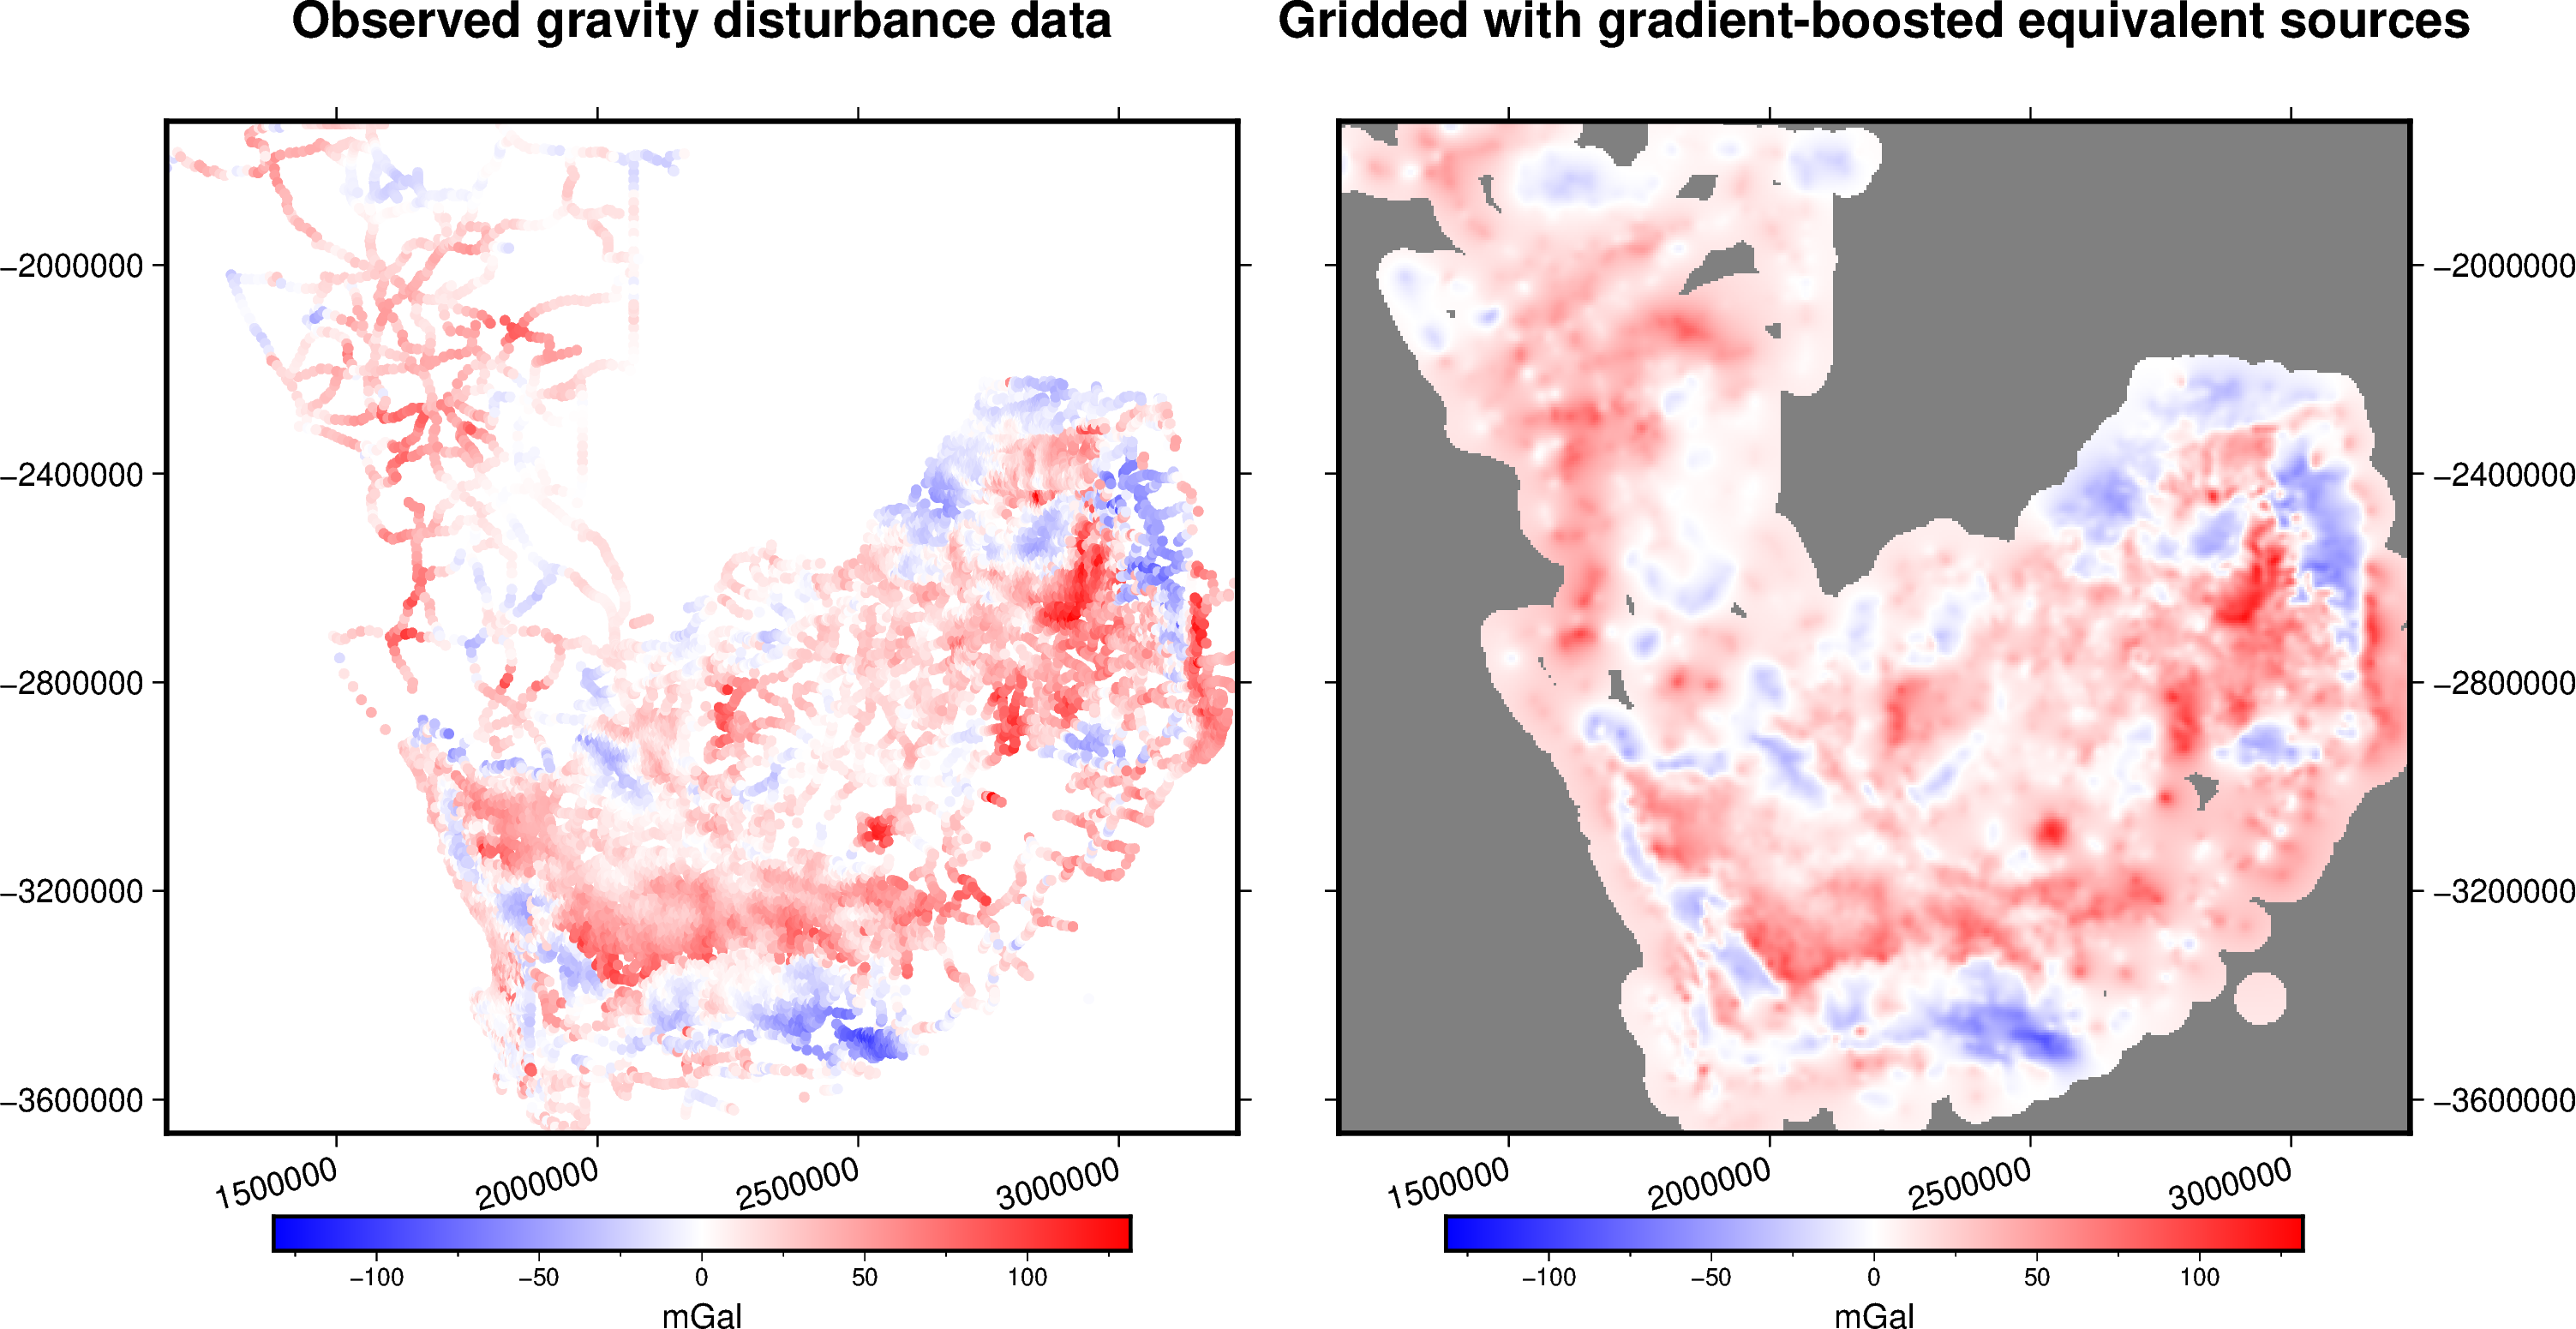

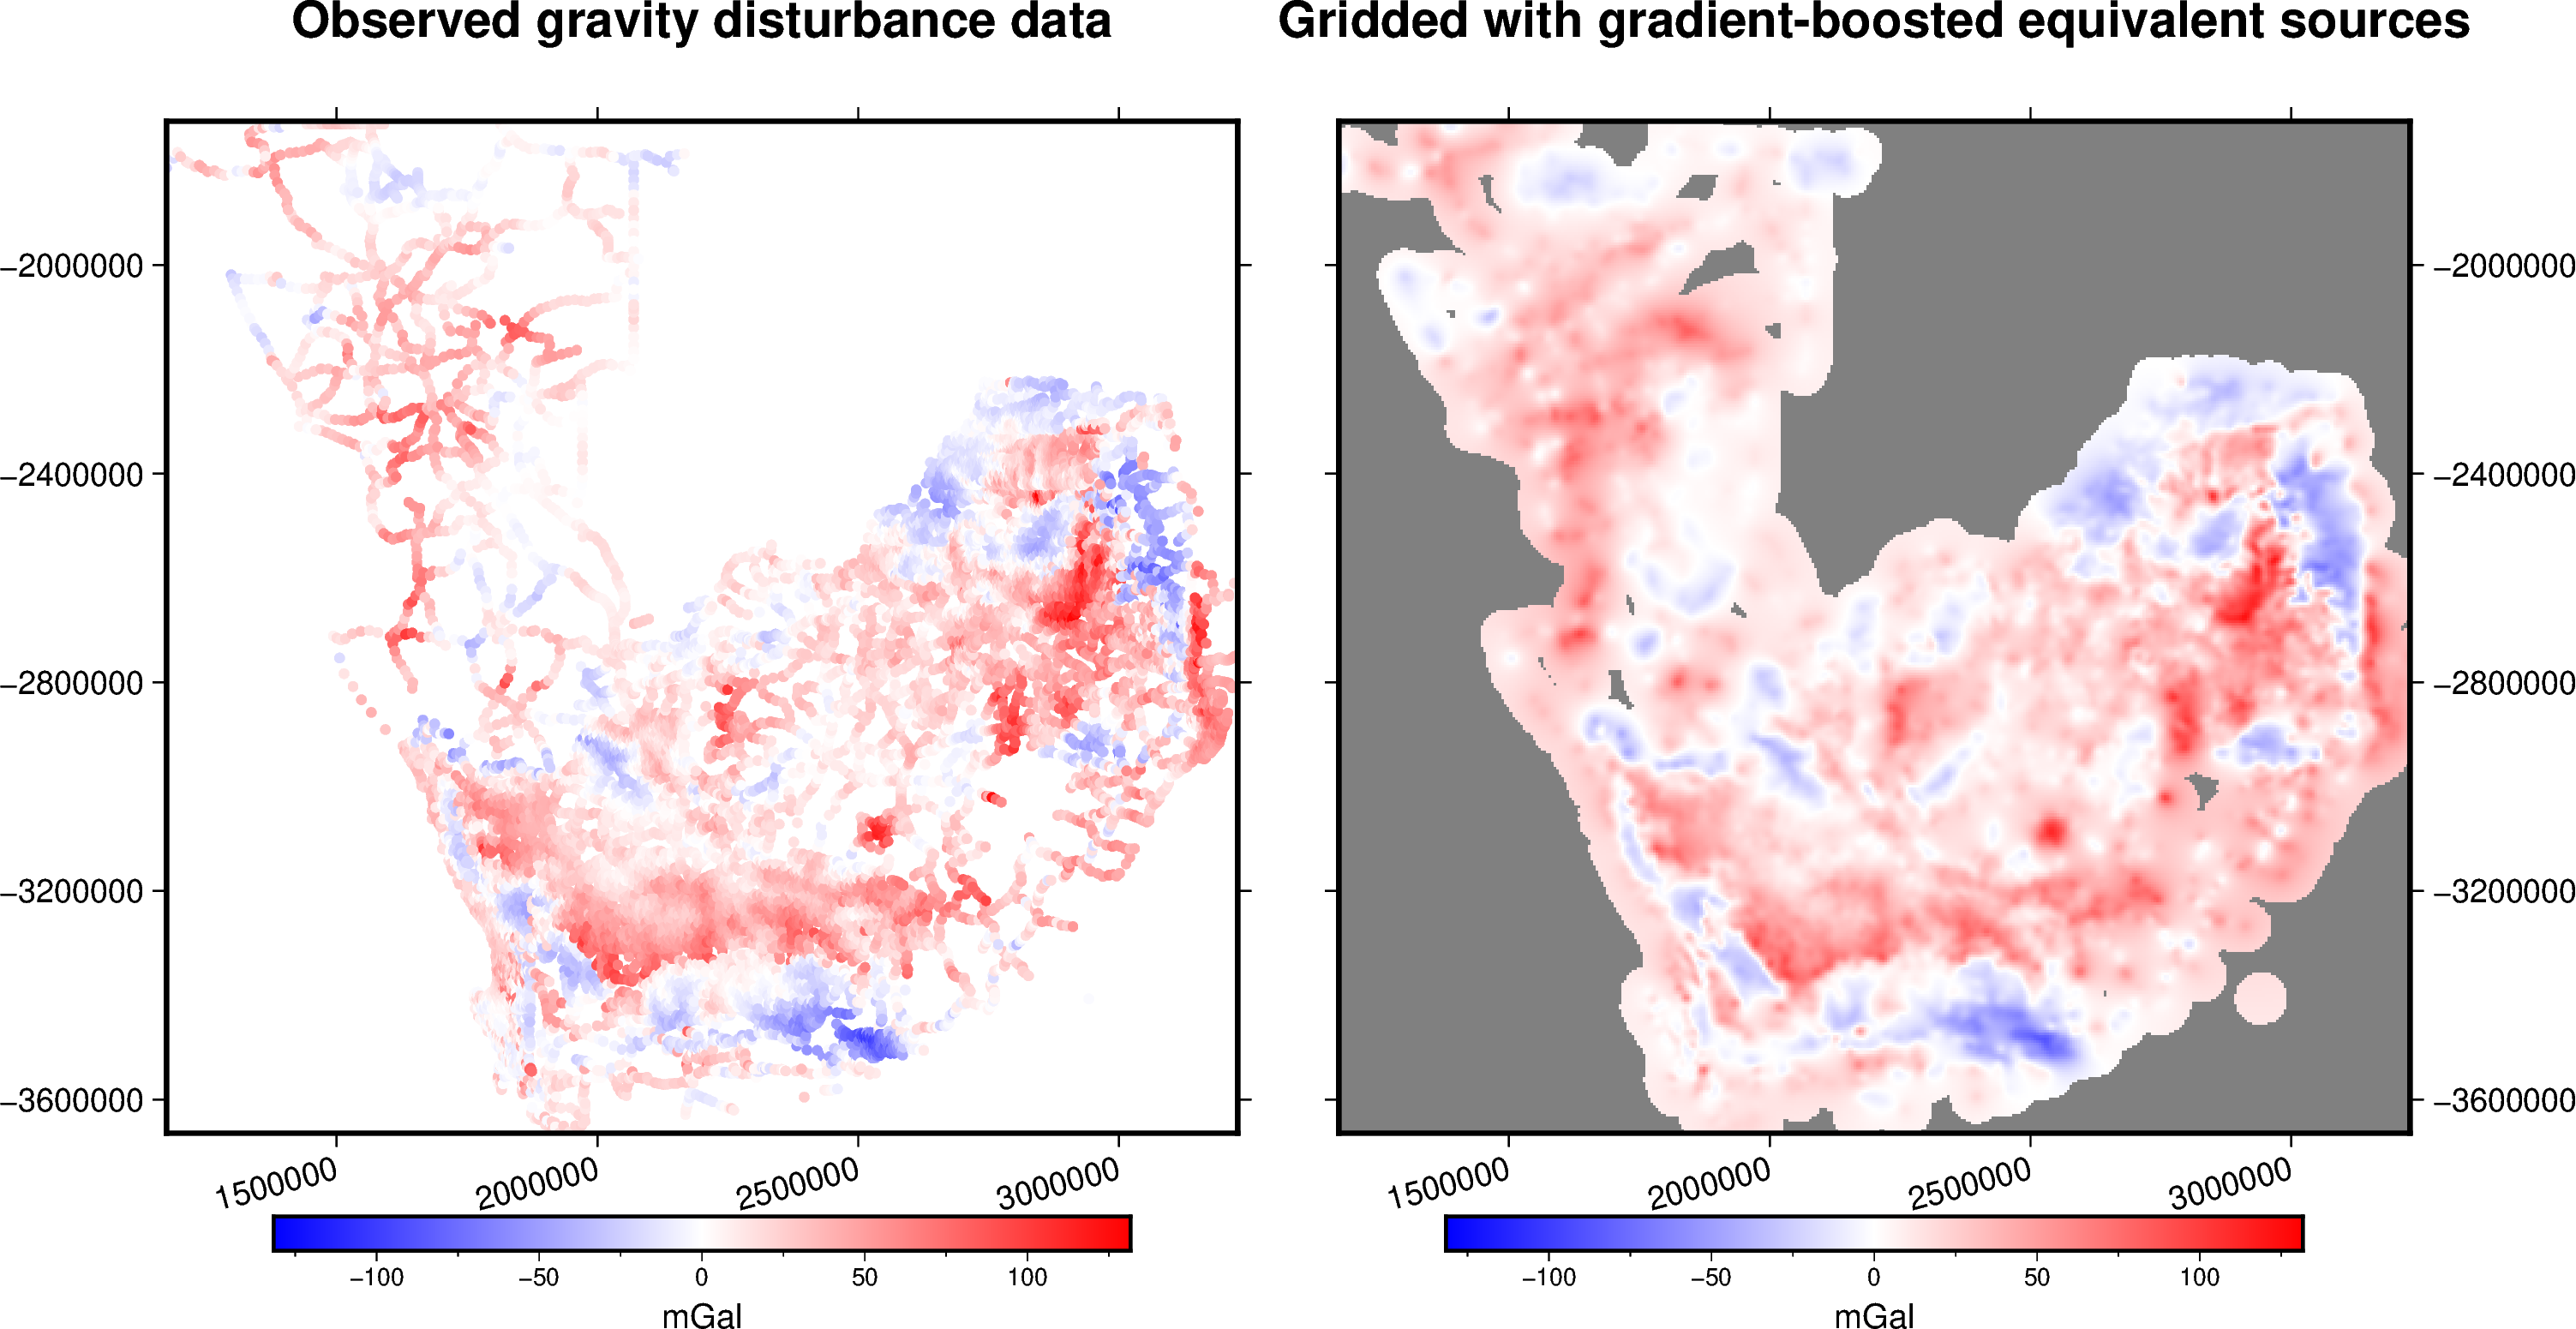

In [41]:
grid_masked_64 = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_64)
grid_masked_32 = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_32)


# Encontrar a escala global 
max_obs = vd.maxabs(gravity_disturbance)
max_64 = vd.maxabs(grid_masked_64.gravity_disturbance)
max_32 = vd.maxabs(grid_masked_32.gravity_disturbance)

limit_global = max(max_obs, max_64, max_32)

# Criar e salvar o arquivo CPT fixo
pygmt.makecpt(
    cmap="polar+h0",
    series=(-limit_global, limit_global),
    background=True,
    output="escala.cpt"  
)

# Set figure properties
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"


# Plotando 64 bits
fig = pygmt.Figure()
title = "Observed gravity disturbance data"
with pygmt.config(FONT_TITLE="14p"):
    fig.plot(
        projection=fig_proj,
        region=region,
        frame=[f"WSne+t{title}", "xa500000+a15", "ya400000"],
        x=easting,
        y=northing,
        fill=gravity_disturbance,
        style="c0.1c",
        cmap="escala.cpt",
    )
fig.colorbar(cmap="escala.cpt", frame=["a50f25", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gridded with gradient-boosted equivalent sources"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        frame=[f"ESnw+t{title}", "xa500000+a15", "ya400000"],
        grid=grid_masked_64.gravity_disturbance,
        cmap="escala.cpt",
    )

fig.colorbar(cmap="escala.cpt", frame=["a50f25", "x+lmGal"])

fig.show()





# Plotando 32 bits
fig = pygmt.Figure()
title = "Observed gravity disturbance data"
with pygmt.config(FONT_TITLE="14p"):
    fig.plot(
        projection=fig_proj,
        region=region,
        frame=[f"WSne+t{title}", "xa500000+a15", "ya400000"],
        x=easting,
        y=northing,
        fill=gravity_disturbance,
        style="c0.1c",
        cmap="escala.cpt",
    )
fig.colorbar(cmap="escala.cpt", frame=["a50f25", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gridded with gradient-boosted equivalent sources"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        frame=[f"ESnw+t{title}", "xa500000+a15", "ya400000"],
        grid=grid_masked_32.gravity_disturbance,
        cmap="escala.cpt",
    )

fig.colorbar(cmap="escala.cpt", frame=["a50f25", "x+lmGal"])

fig.show()

Plotagem do grid diferença

Diferença Máxima: +/- 1.249982e-01 mGal


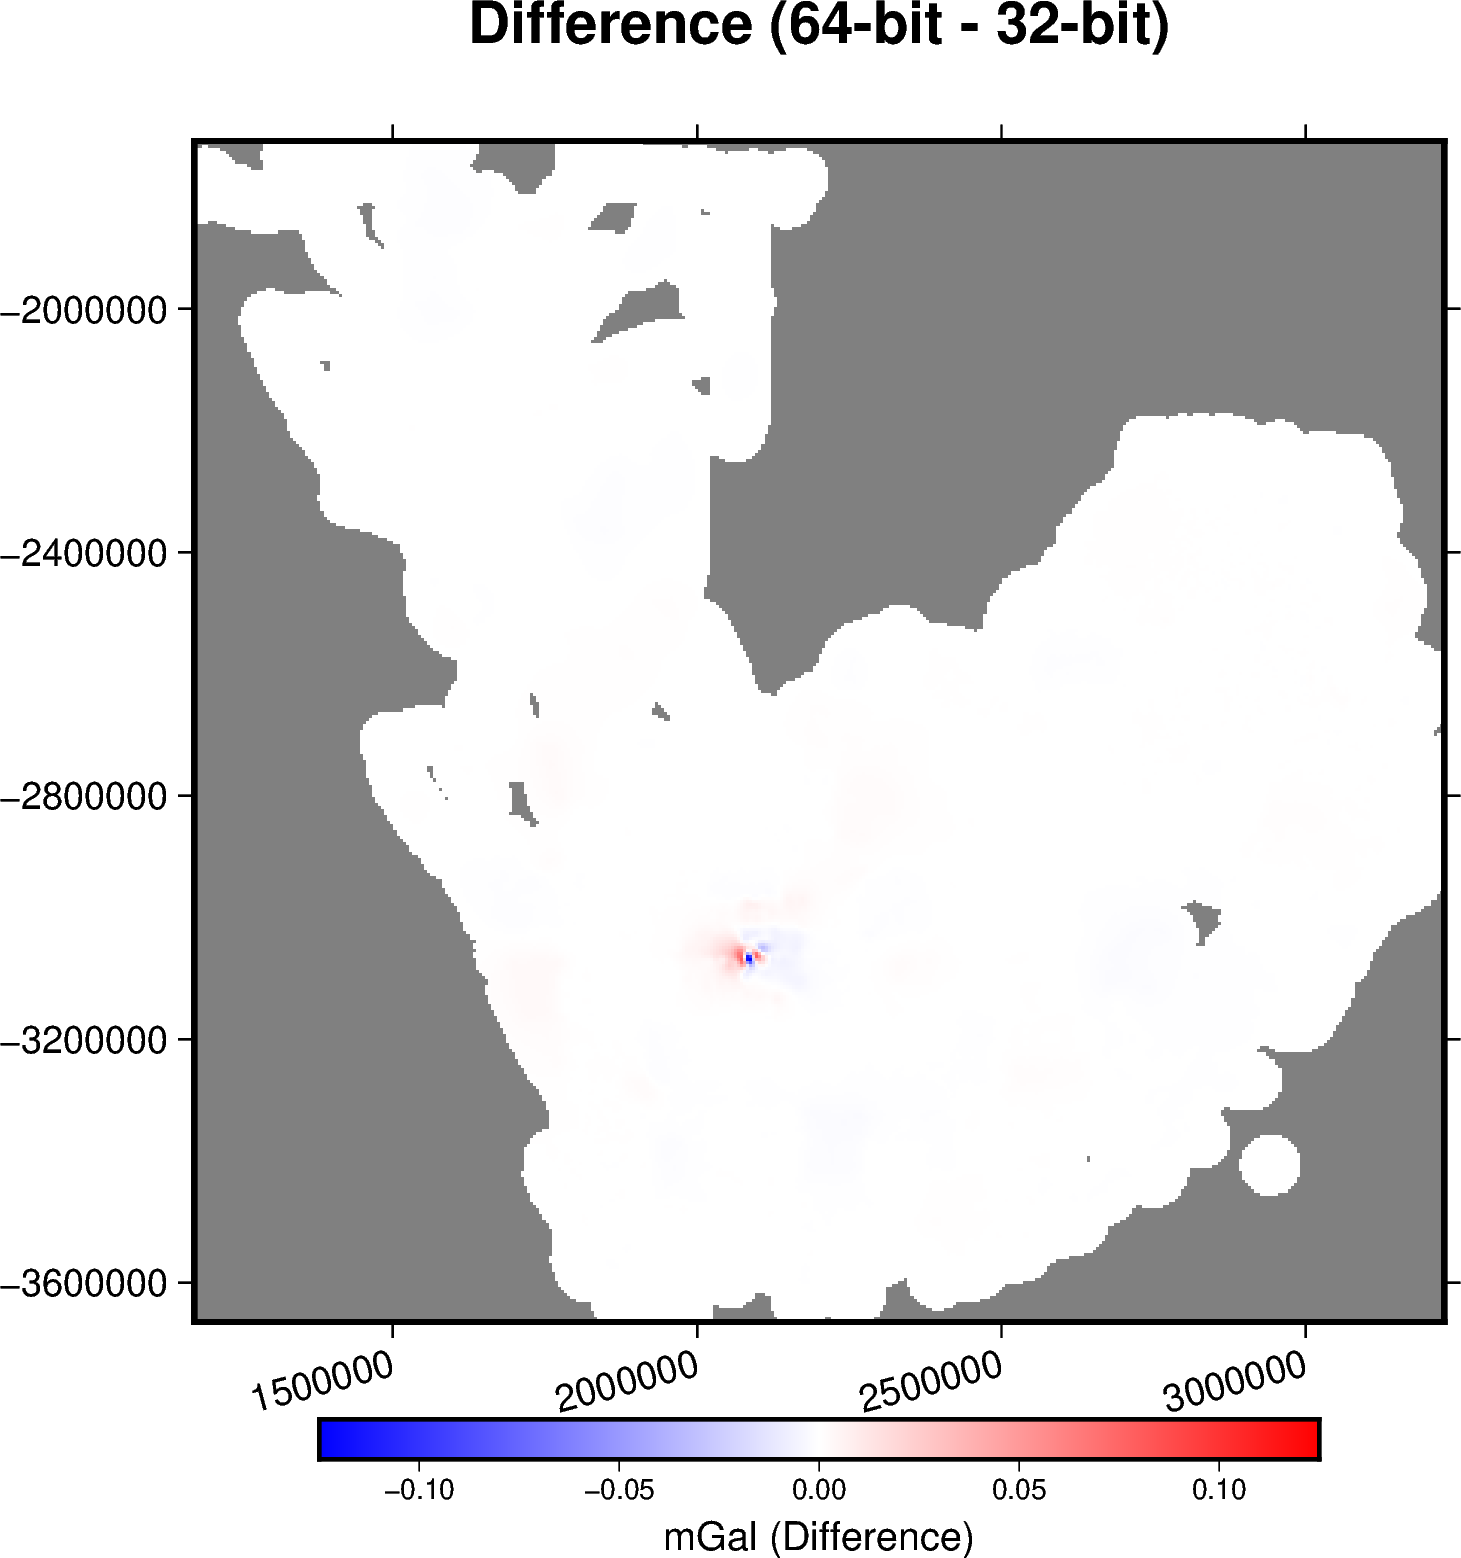

In [42]:

# Calcular a diferença
grid_diff = grid_masked_64 - grid_masked_32

# Calcular a escala para a diferença
max_diff = vd.maxabs(grid_diff.gravity_disturbance)
print(f"Diferença Máxima: +/- {max_diff:.6e} mGal")

# Criar CPT específico para a diferença
pygmt.makecpt(
    cmap="polar+h0",
    series=(-max_diff, max_diff),
    background=True,
    output="gravity_diff.cpt"
)
fig = pygmt.Figure()
title = "Difference (64-bit - 32-bit)"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        projection=fig_proj,
        region=region,
        frame=[f"WSne+t{title}", "xa500000+a15", "ya400000"],
        grid=grid_diff.gravity_disturbance,
        cmap="gravity_diff.cpt",
    )

fig.colorbar(cmap="gravity_diff.cpt", frame=["a", "x+lmGal (Difference)"])

fig.show()

In [43]:
valores_64 = grid_64.gravity_disturbance.values
valores_32 = grid_32.gravity_disturbance.values

mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} mGal")

media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids é: 1.3257770822251727e-06
A Raiz do Erro Quadrático Médio (RMSE) é: 0.0012 mGal
O erro dividido pela média dos valores absolutos dos dados é: 7.383498852356602e-05
O erro relativo à amplitude dos dados é: 5.435163509513066e-06


Proporção pontos de entrada e tamanho do grid

In [44]:
pontos_entrada = len(gravity_disturbance)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

14359
160268


### 2º Teste Harmonica - Função Fit EquivalentSources

In [45]:
fname = ensaio.fetch_britain_magnetic(version=1)
data = pd.read_csv(fname)
data

,line_and_segment,year,longitude,latitude,height_m,total_field_anomaly_nt
0,FL1-1,1955,-1.74162,53.48164,792,62
1,FL1-1,1955,-1.70122,53.48352,663,56
2,FL1-1,1955,-1.08051,53.47677,315,30
3,FL1-1,1955,-1.07471,53.47672,315,31
4,FL1-1,1955,-1.01763,53.47586,321,44
...,...,...,...,...,...,...
541503,FL-3(TL10-24)-1,1965,-4.68843,58.26786,1031,64
541504,FL-3(TL10-24)-1,1965,-4.68650,58.26786,1045,74
541505,FL-3(TL10-24)-1,1965,-4.68535,58.26790,1035,94
541506,FL-3(TL10-24)-1,1965,-4.68419,58.26787,1024,114


In [46]:
region = (-5.5, -4.7, 57.8, 58.5)
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
data

,line_and_segment,year,longitude,latitude,height_m,total_field_anomaly_nt
383858,FL-47-2,1964,-5.38345,57.95592,305,112
383859,FL-47-2,1964,-5.38180,57.95614,305,120
383860,FL-47-2,1964,-5.38011,57.95633,305,150
383861,FL-47-2,1964,-5.37851,57.95658,305,170
383862,FL-47-2,1964,-5.37650,57.95693,305,220
...,...,...,...,...,...,...
538970,FL-16(TL24-36)-6,1965,-4.70304,58.49978,319,162
541490,FL-11-5,1965,-4.88674,58.40691,1056,245
541491,FL-11-5,1965,-4.88377,58.40689,1069,250
541492,FL-11-5,1965,-4.88202,58.40724,1055,245


In [47]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_m)
xy_region=vd.get_region(coordinates)

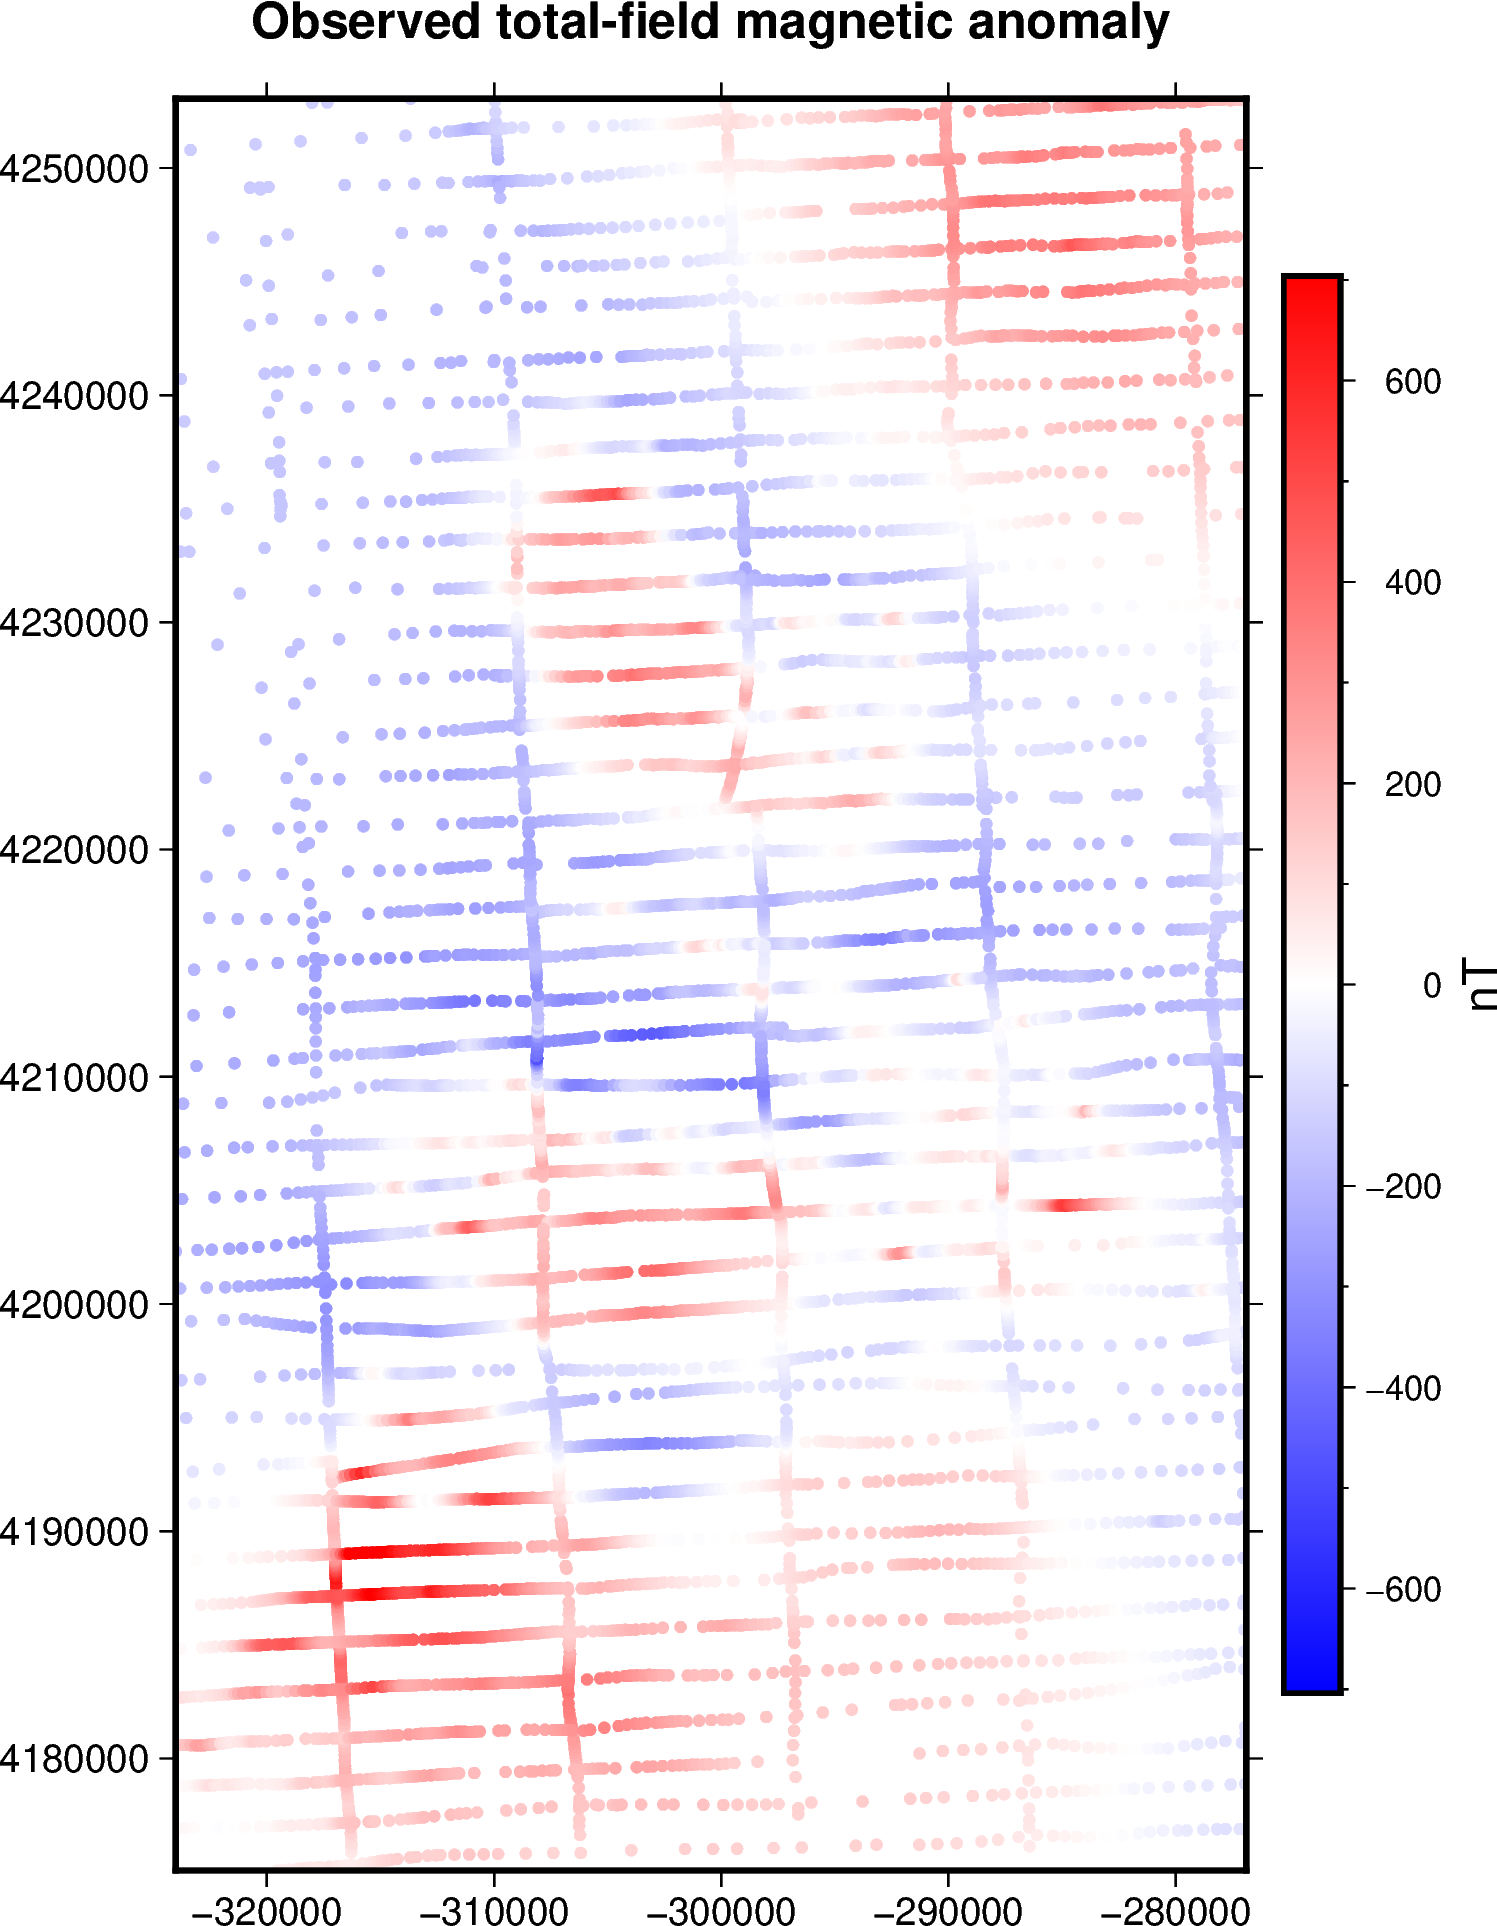

In [48]:
maxabs = vd.maxabs(data.total_field_anomaly_nt)*.8

# Set figure properties
w, e, s, n = xy_region
fig_height = 15
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

# Plot original magnetic anomaly and the gridded and upward-continued version
fig = pygmt.Figure()

title = "Observed total-field magnetic anomaly"

pygmt.makecpt(
    cmap="polar+h0",
    series=(-maxabs, maxabs),
    background=True,
)

with pygmt.config(FONT_TITLE="12p"):
    fig.plot(
        projection=fig_proj,
        region=xy_region,
        frame=[f"WSne+t{title}", "xa10000", "ya10000"],
        x=easting,
        y=northing,
        fill=data.total_field_anomaly_nt,
        style="c0.1c",
        cmap=True,
    )
fig.colorbar(cmap=True, position="JMR", frame=["a200f100", "x+lnT"])
fig.show()

In [49]:
# Profile com 64 bits

# Cria-se uma instância de Eqs
eqs_64 = hm.EquivalentSources(depth=1000, damping=1, block_size=500)
# Realiza-se a interpolação com os dados passados 
%lprun -f hm.EquivalentSources.fit eqs_64.fit(coordinates, data.total_field_anomaly_nt)

/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


Timer unit: 1e-09 s

Total time: 2.32947 s
File: /mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/cartesian.py
Function: EquivalentSources.fit at line 192

Line #      Hits         Time  Per Hit   % Time  Line Contents
   192                                               def fit(self, coordinates, data, weights=None, dtype=None):
   193                                                   """
   194                                                   Fit the coefficients of the equivalent sources.
   195                                           
   196                                                   The data region is captured and used as default for the
   197                                                   :meth:`~harmonica.EquivalentSources.grid` method.
   198                                           
   199                                                   All input arrays must have the same shape.
   200                                           
   201                  

In [50]:
# Profile com 32 bits

# Cria-se uma instância de Eqs
eqs_32 = hm.EquivalentSources(
    depth=1000, damping=1, block_size=500
)
# Realiza-se a interpolação com os dados passados 
%lprun -f hm.EquivalentSources.fit eqs_32.fit(coordinates, data.total_field_anomaly_nt, dtype="float32")

/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.315888422316675e-09.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Timer unit: 1e-09 s

Total time: 0.9129 s
File: /mnt/HD/pesquisa/harmonica/harmonica/_equivalent_sources/cartesian.py
Function: EquivalentSources.fit at line 192

Line #      Hits         Time  Per Hit   % Time  Line Contents
   192                                               def fit(self, coordinates, data, weights=None, dtype=None):
   193                                                   """
   194                                                   Fit the coefficients of the equivalent sources.
   195                                           
   196                                                   The data region is captured and used as default for the
   197                                                   :meth:`~harmonica.EquivalentSources.grid` method.
   198                                           
   199                                                   All input arrays must have the same shape.
   200                                           
   201                   

In [51]:
## Código com benchmarking ## 
resultados_benchmark_spline = []
n_repeticoes = 21



for i in range(n_repeticoes):
    
    start_time = time.perf_counter()
    # Utilizar a classe Spline para interpolar os dados do GPS


    # Realiza-se a interpolação com os dados passados (easting, northing)
    eqs_64.fit(coordinates, data.total_field_anomaly_nt)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_spline.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()
    # Utilizar a classe Spline para interpolar os dados do GPS

    # Realiza-se a interpolação com os dados passados (easting, northing)
    eqs_32.fit(coordinates, data.total_field_anomaly_nt, dtype="float32")
    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_spline.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_spline.pop(0)
resultados_benchmark_spline.pop(n_repeticoes)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_spline)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados

/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
/mnt/HD/pesquisa/verde/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x75d41c205f80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio


--- Estatísticas Descritivas por Versão ---
         count      mean       std       min       25%       50%       75%  \
Versão                                                                       
32 bits   20.0  1.398608  0.152416  1.217064  1.292240  1.381287  1.438966   
64 bits   20.0  2.333411  0.370567  1.713299  2.156658  2.411830  2.572923   

              max  
Versão             
32 bits  1.766675  
64 bits  2.787884  


/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.315888422316675e-09.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,Versão,Rodada,Duração
0,64 bits,2,1.740220
1,64 bits,3,1.768330
2,64 bits,4,1.713299
3,64 bits,5,1.718707
4,64 bits,6,1.852875
5,64 bits,7,2.257919
6,64 bits,8,2.372718
7,64 bits,9,2.787884
8,64 bits,10,2.558666
9,64 bits,11,2.615693


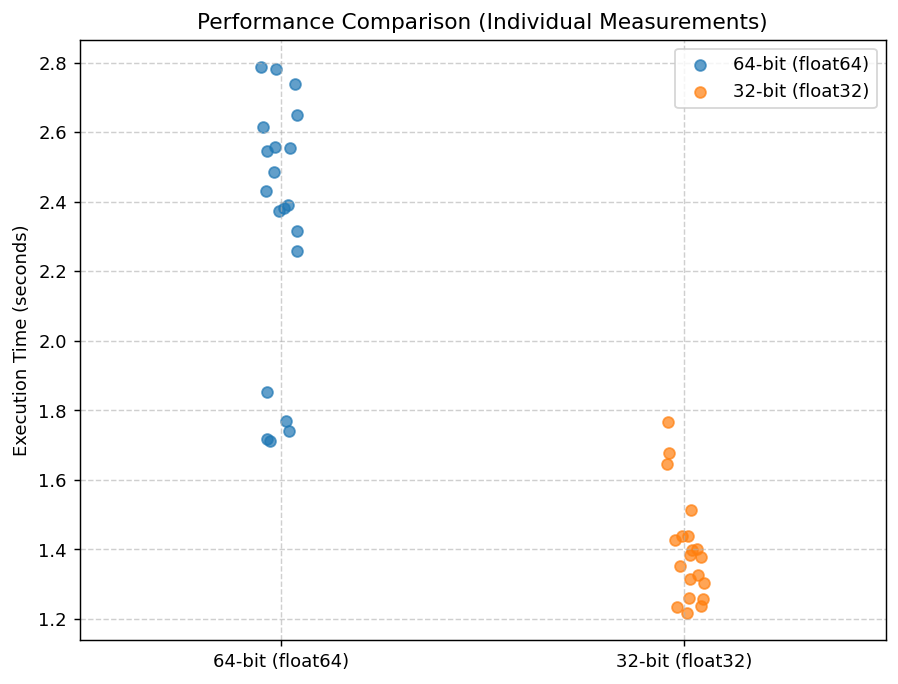

14359
160268


/tmp/ipykernel_21398/4269044243.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


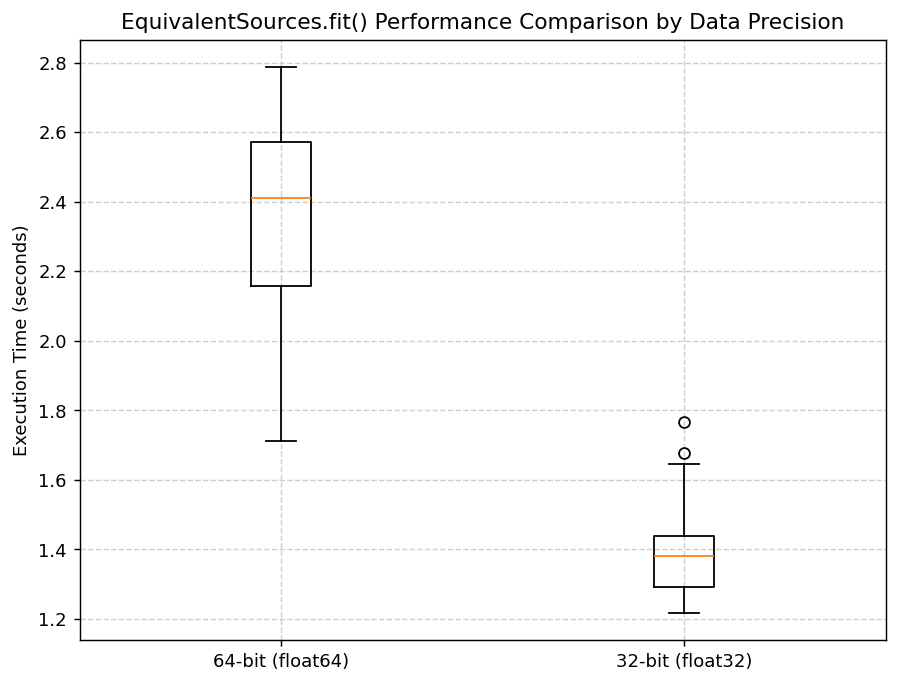

In [52]:
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Performance Comparison (Individual Measurements)')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_caribe.png")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('EquivalentSources.fit() Performance Comparison by Data Precision')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dadospontos_entrada = len(gravity_disturbance)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)
plt.show()

In [53]:
grid_coords = vd.grid_coordinates(
    region=vd.get_region(coordinates),
    spacing=500,
    extra_coords=1500,
)
grid_64 = eqs_64.grid(grid_coords, data_names=["magnetic_anomaly"])
grid_64




<xarray.Dataset> Size: 241kB
Dimensions:           (northing: 157, easting: 95)
Coordinates:
  * easting           (easting) float64 760B -3.24e+05 -3.235e+05 ... -2.769e+05
  * northing          (northing) float64 1kB 4.175e+06 4.176e+06 ... 4.253e+06
    upward            (northing, easting) float64 119kB 1.5e+03 ... 1.5e+03
Data variables:
    magnetic_anomaly  (northing, easting) float64 119kB 30.31 30.5 ... 151.0
Attributes:
    metadata:  Generated by EquivalentSources(block_size=500, damping=1, dept...

In [54]:
grid_32 = eqs_32.grid(grid_coords, data_names=["magnetic_anomaly"])
grid_32


<xarray.Dataset> Size: 241kB
Dimensions:           (northing: 157, easting: 95)
Coordinates:
  * easting           (easting) float64 760B -3.24e+05 -3.235e+05 ... -2.769e+05
  * northing          (northing) float64 1kB 4.175e+06 4.176e+06 ... 4.253e+06
    upward            (northing, easting) float64 119kB 1.5e+03 ... 1.5e+03
Data variables:
    magnetic_anomaly  (northing, easting) float64 119kB 30.26 30.46 ... 151.0
Attributes:
    metadata:  Generated by EquivalentSources(block_size=500, damping=1, dept...

Gerando plotagem 64 bits...


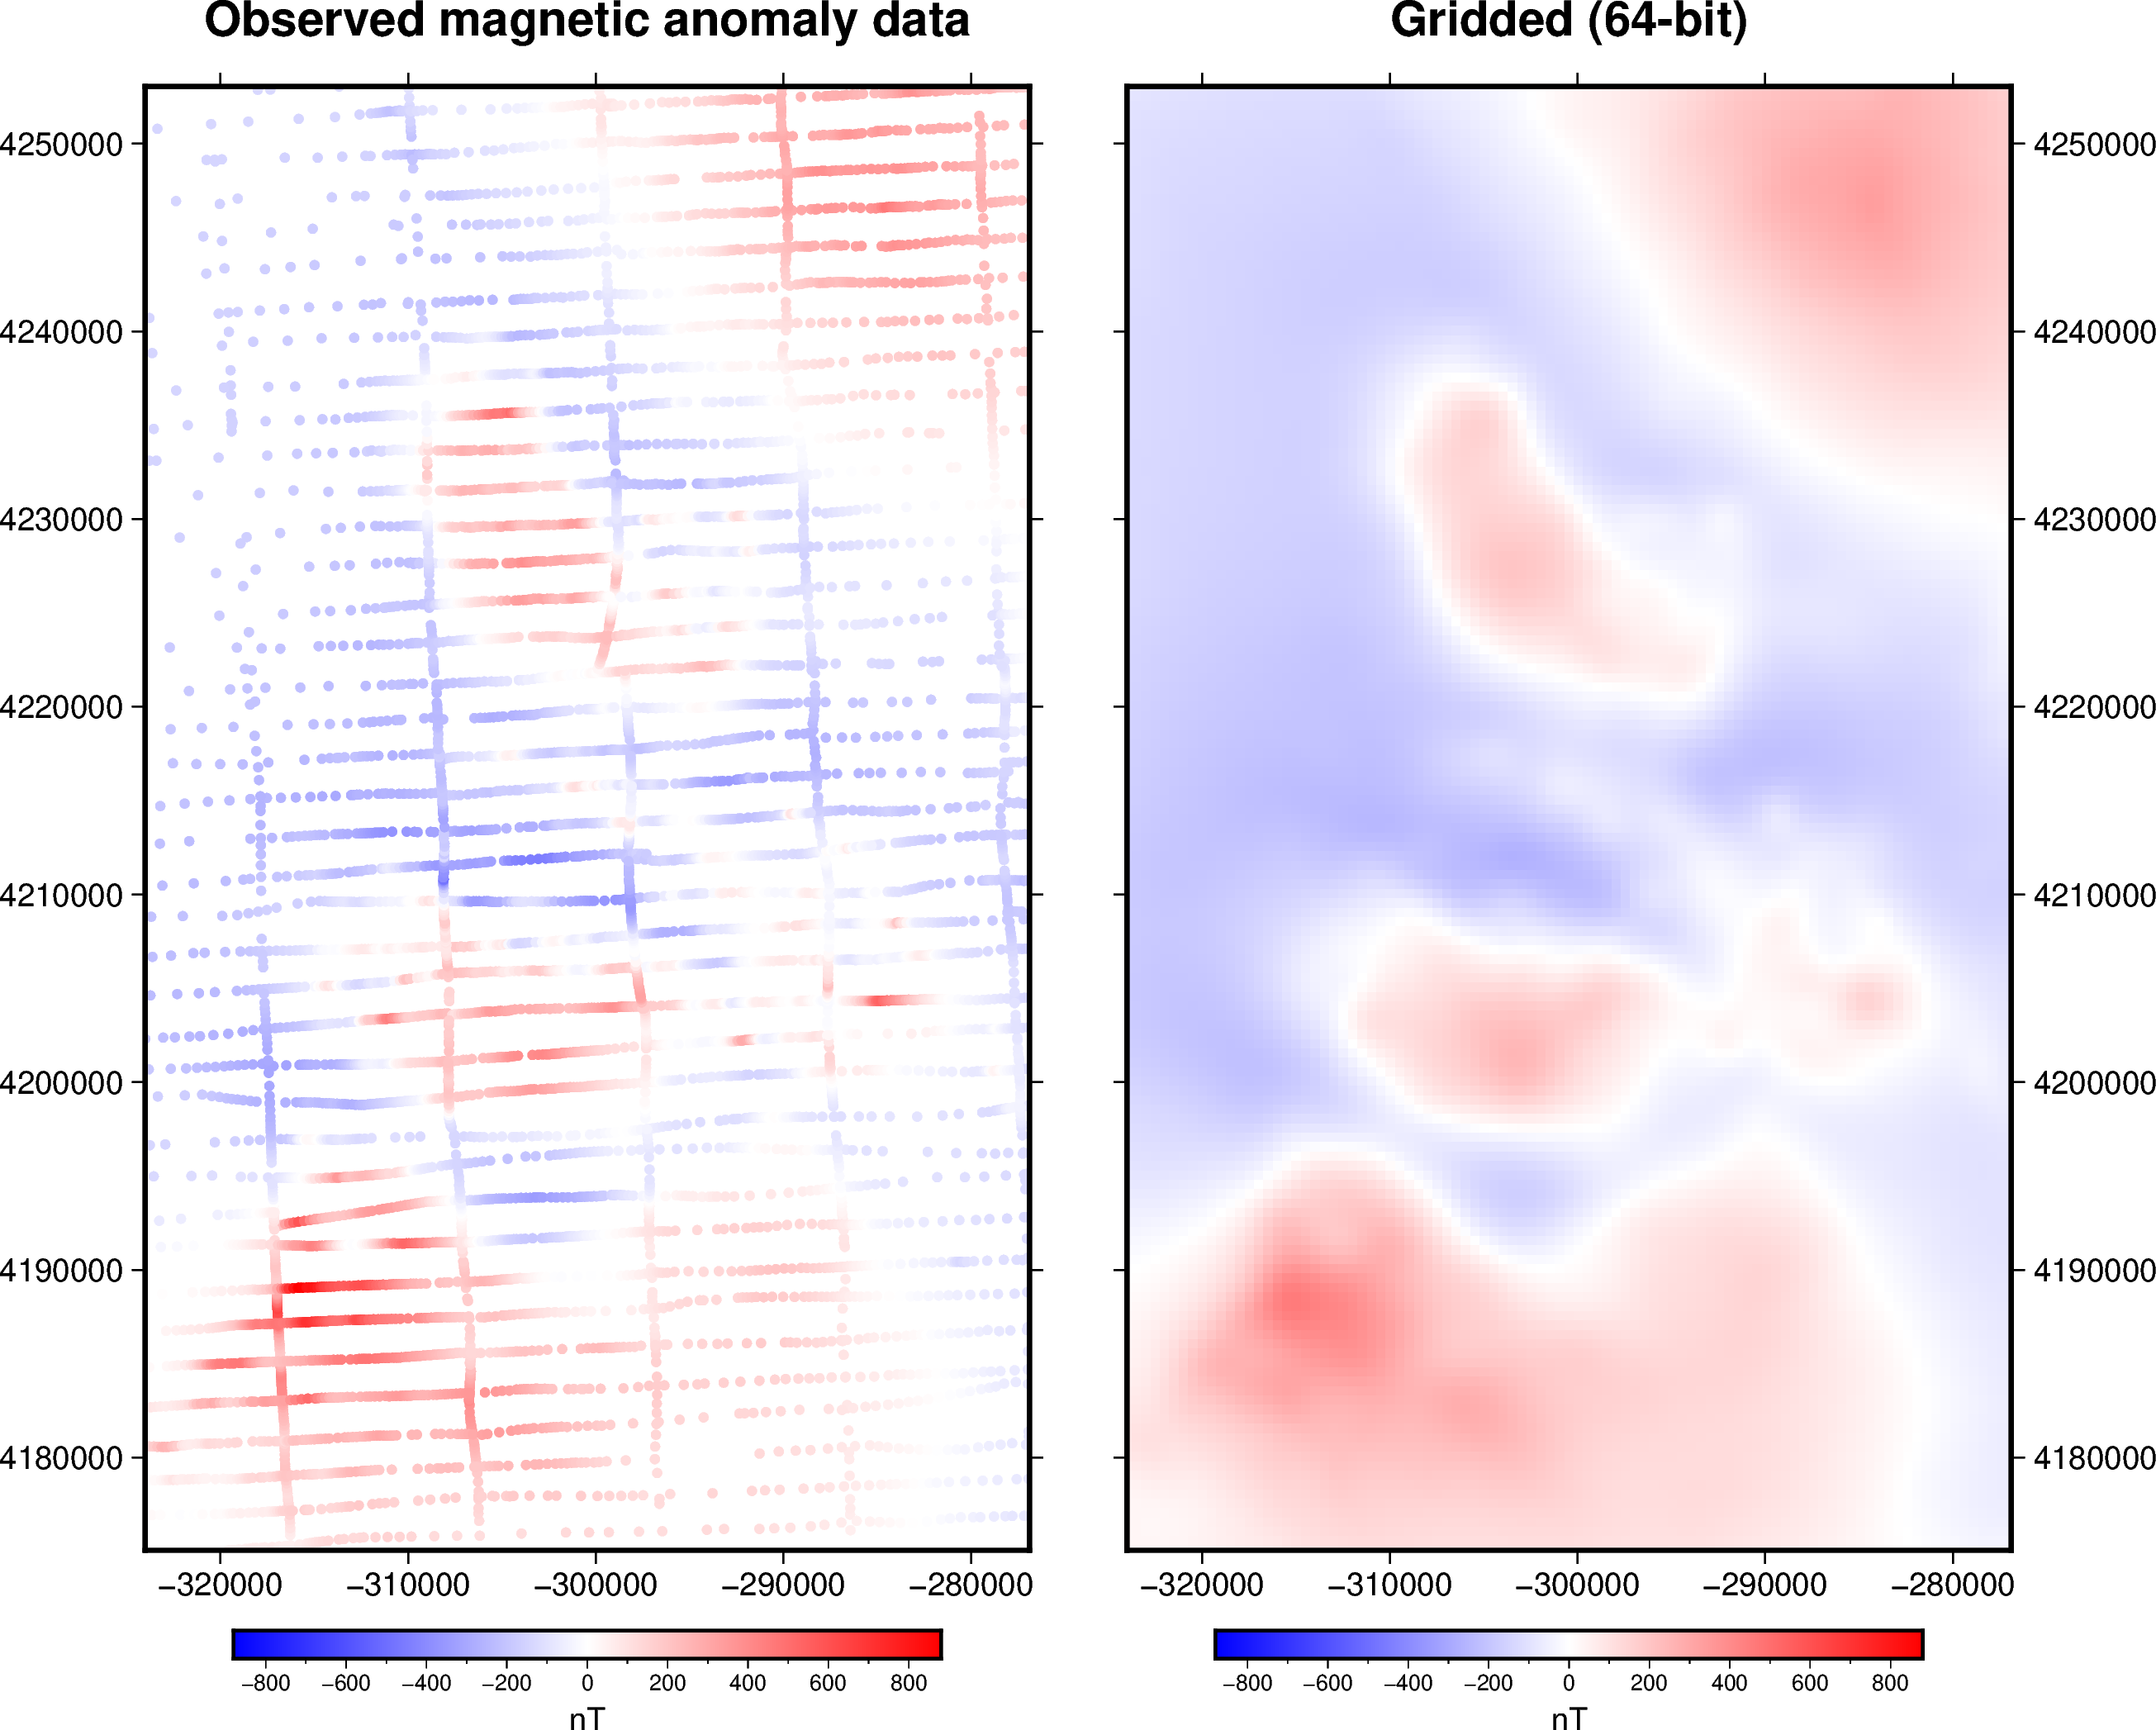

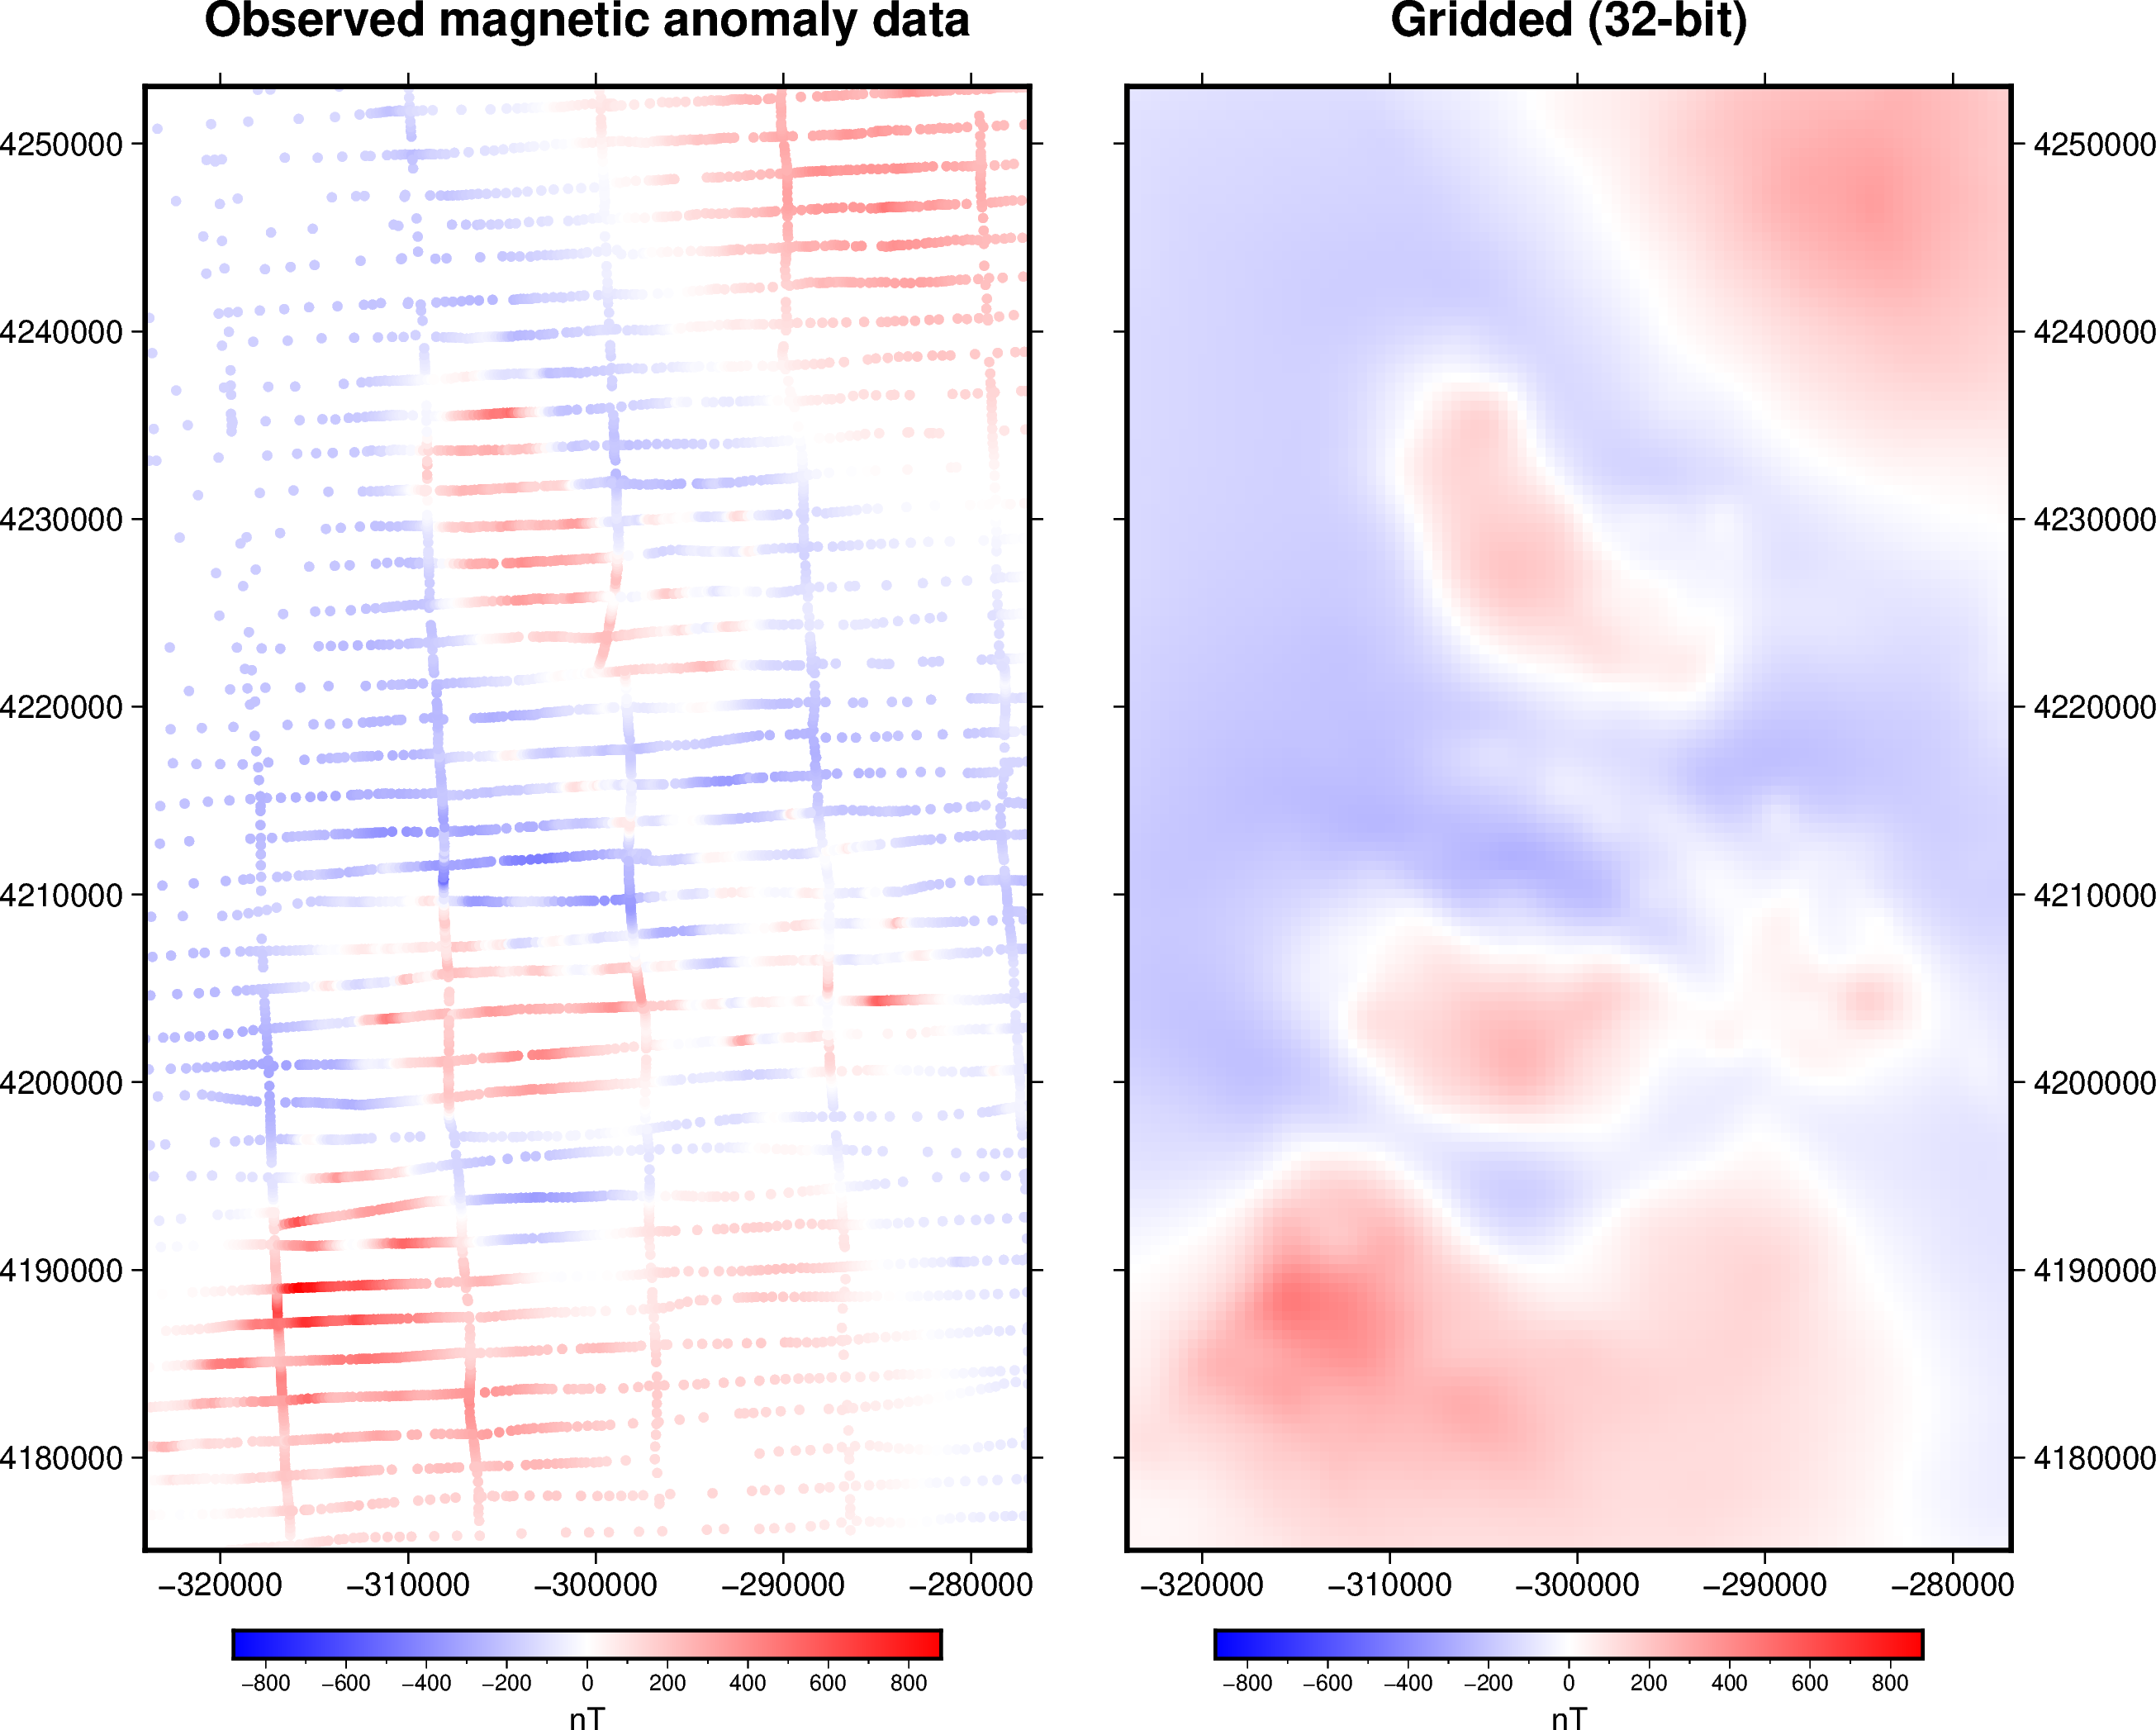

In [55]:
# Encontrar o valor máximo absoluto entre os dados
max_obs = vd.maxabs(data.total_field_anomaly_nt)
max_64 = vd.maxabs(grid_64.magnetic_anomaly)
max_32 = vd.maxabs(grid_32.magnetic_anomaly)

global_max = max(max_obs, max_64, max_32)

# Criar o arquivo CPT no disco
pygmt.makecpt(
    cmap="polar+h0",
    series=(-global_max, global_max),
    background=True,
    output="escala.cpt" 
)


# Plotando 64 bits
print("Gerando plotagem 64 bits...")
fig = pygmt.Figure()

title = "Observed magnetic anomaly data"
with pygmt.config(FONT_TITLE="14p"):
    fig.plot(
        projection=fig_proj,
        region=xy_region,
        frame=[f"WSne+t{title}", "xa10000", "ya10000"],
        x=easting,
        y=northing,
        fill=data.total_field_anomaly_nt,
        style="c0.1c",
        cmap="escala.cpt", # Usa o arquivo salvo
    )
fig.colorbar(cmap="escala.cpt", frame=["a200f100", "x+lnT"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gridded (64-bit)"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        frame=[f"ESnw+t{title}", "xa10000", "ya10000"],
        grid=grid_64.magnetic_anomaly,
        cmap="escala.cpt", # Usa o mesmo arquivo
    )
fig.colorbar(cmap="escala.cpt", frame=["a200f100", "x+lnT"])

fig.show()

# Plotando 32 bits
fig = pygmt.Figure()

# Esquerda: Dados Observados (Repetição visual para comparação)
title = "Observed magnetic anomaly data"
with pygmt.config(FONT_TITLE="14p"):
    fig.plot(
        projection=fig_proj,
        region=xy_region,
        frame=[f"WSne+t{title}", "xa10000", "ya10000"],
        x=easting,
        y=northing,
        fill=data.total_field_anomaly_nt,
        style="c0.1c",
        cmap="escala.cpt",
    )
fig.colorbar(cmap="escala.cpt", frame=["a200f100", "x+lnT"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gridded (32-bit)"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        frame=[f"ESnw+t{title}", "xa10000", "ya10000"],
        grid=grid_32.magnetic_anomaly,
        cmap="escala.cpt",
    )
fig.colorbar(cmap="escala.cpt", frame=["a200f100", "x+lnT"])

fig.show()

Plotagem do grid diferença


Diferença Máxima: +/- 3.339689e-01 nT


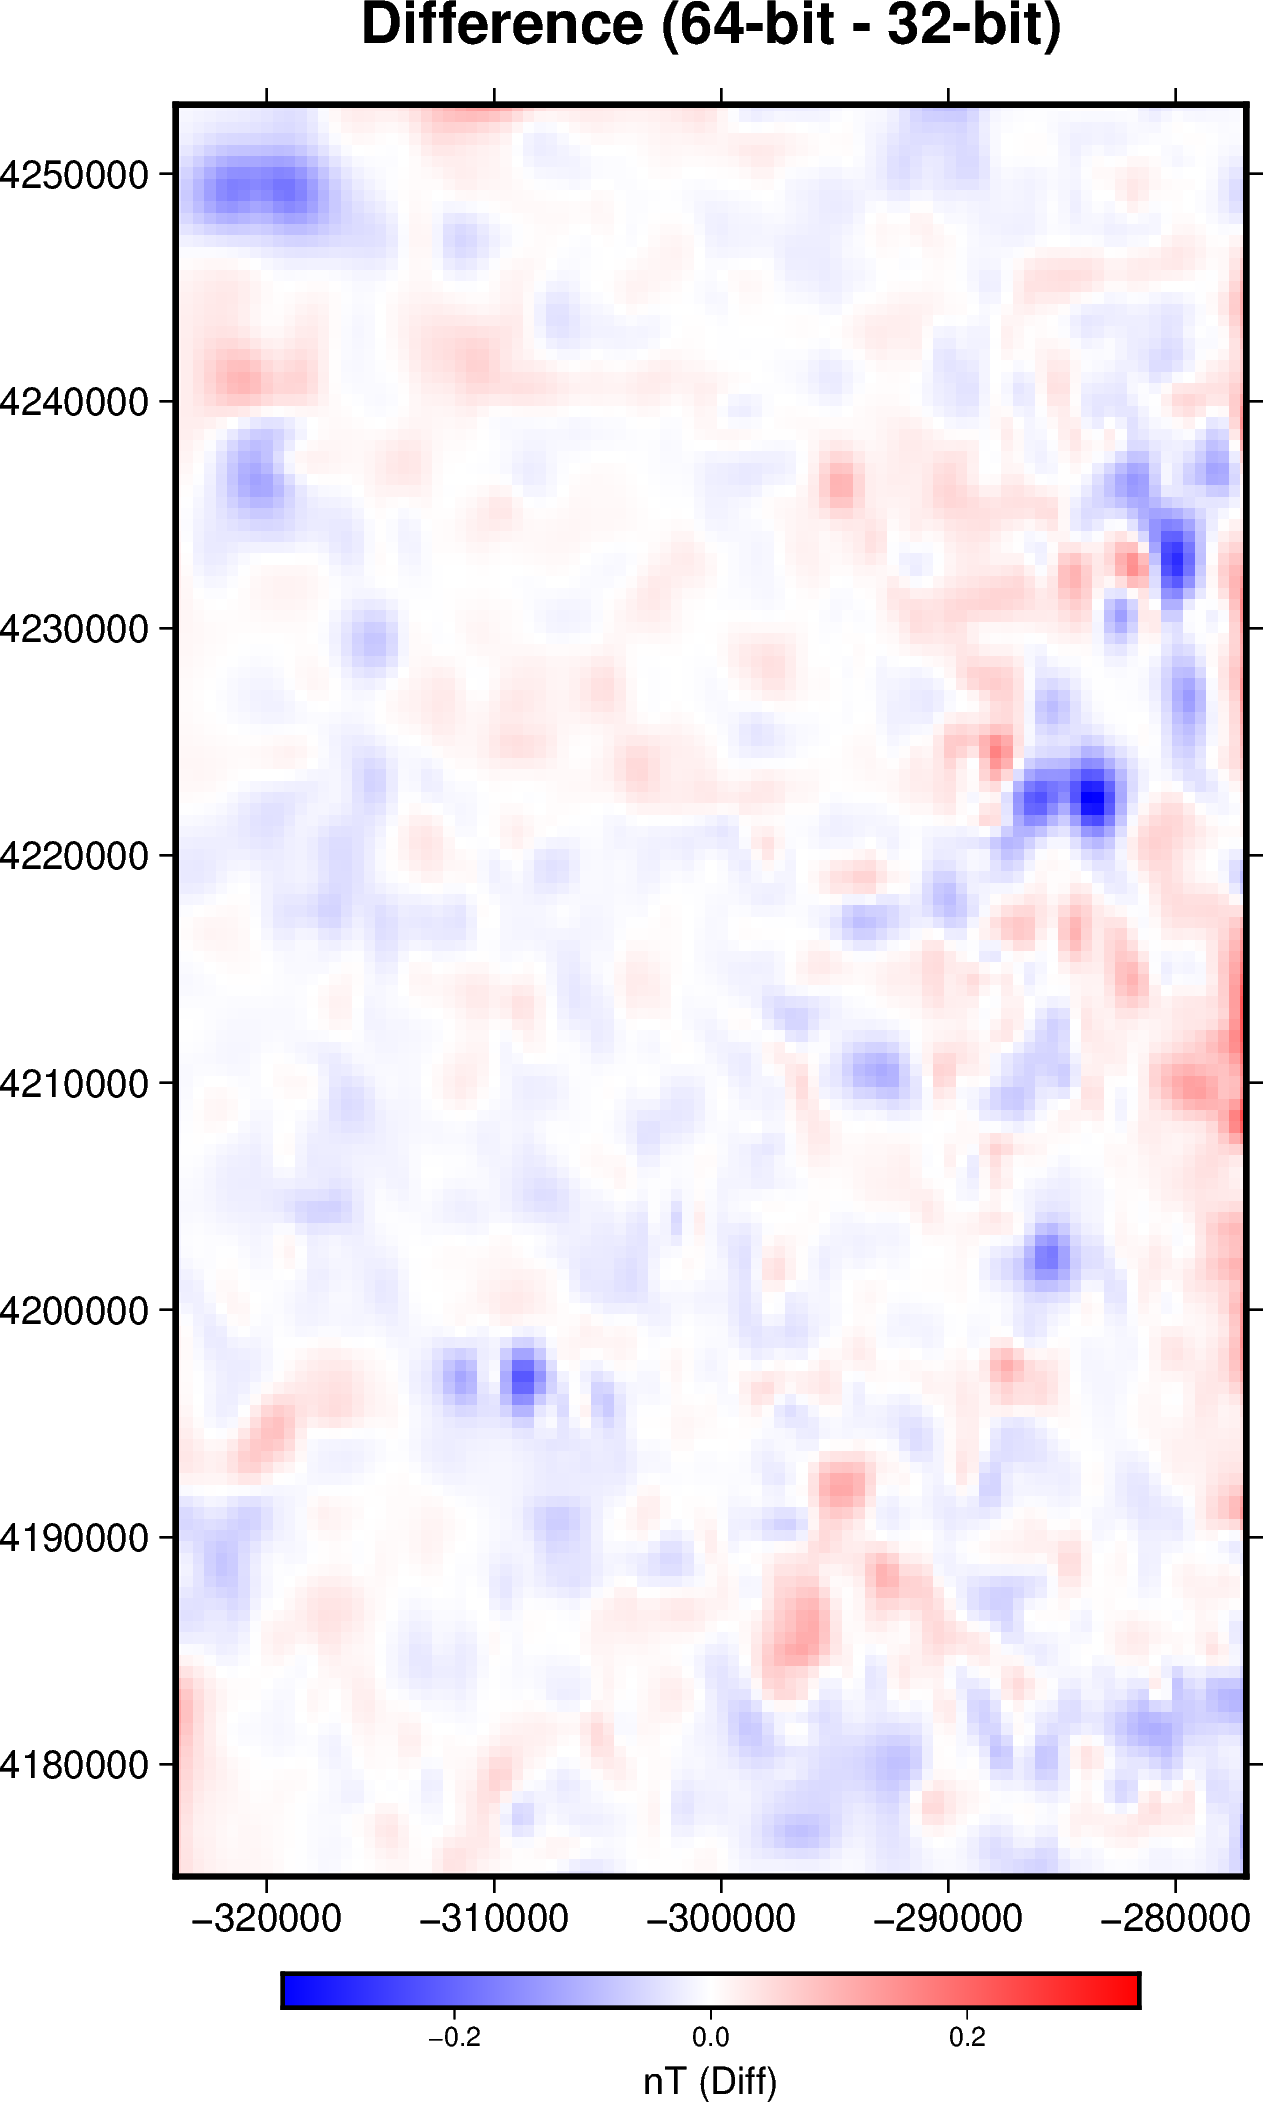

In [56]:

# Calcular o grid de diferença
grid_diff_mag = grid_64.magnetic_anomaly - grid_32.magnetic_anomaly

# Calcular limites para a escala de diferença
max_diff = vd.maxabs(grid_diff_mag)
print(f"Diferença Máxima: +/- {max_diff:.6e} nT")

# Criar CPT específico para a diferença
pygmt.makecpt(
    cmap="polar+h0", 
    series=(-max_diff, max_diff),
    background=True,
    output="mag_diff.cpt"
)

fig = pygmt.Figure()

title = "Difference (64-bit - 32-bit)"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        projection=fig_proj,
        region=xy_region,
        frame=[f"WSne+t{title}", "xa10000", "ya10000"],
        grid=grid_diff_mag,
        cmap="mag_diff.cpt",
    )

fig.colorbar(cmap="mag_diff.cpt", frame=["a", "x+lnT (Diff)"])

fig.show()

Cálculo do erro numérico

In [57]:
valores_64 = grid_64.magnetic_anomaly.values
valores_32 = grid_32.magnetic_anomaly.values

mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids é: 0.0011145354967054845
A Raiz do Erro Quadrático Médio (RMSE) é: 0.0334 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.00027955850461667154
O erro relativo à amplitude dos dados é: 4.608975239821949e-05


Proporção número de pontos da entrada e tamanho do grid

In [58]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

7054
14915
